# Complex Tables in python-docx

How to transform html table with arbitrary colspans and rowspans into python-docx table?

Transforming an HTML table with arbitrary colspans and rowspans into a python-docx table is a complex task. Here's a step-by-step plan:

1. Parse the HTML table using a library like BeautifulSoup.
2. Create a 2D list (list of lists) to represent the table. Each sublist represents a row, and each element in the sublist represents a cell. Initialize all cells with `None`.
3. Iterate over the rows and cells in the HTML table. For each cell, find the first `None` element in the 2D list and set it to the cell content. If the cell has a colspan or rowspan, set the appropriate number of elements in the 2D list to the cell content.
4. Create a python-docx table with the same number of rows and columns as the 2D list.
5. Iterate over the cells in the 2D list. For each cell, if it's the same as the previous cell in the same row or column, merge the corresponding cells in the python-docx table.

Here's a simplified version of the code:

_Please note that this code assumes that all rows in the HTML table have the same number of cells, and that the colspan and rowspan attributes are used correctly. If this is not the case, you'll need to modify the code accordingly. Also, this code does not handle cell formatting. If you want to preserve the formatting of the cells, you'll need to add code to copy the formatting from the HTML table to the python-docx table._

In [1]:
html = '''
<table border="1" cellpadding="1" cellspacing="1" style="width:500px">
	<tbody>
		<tr>
			<td>test</td>
			<td colspan="2" rowspan="1">test</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td colspan="1" rowspan="2">test</td>
			<td>&nbsp;</td>
			<td>test</td>
		</tr>
		<tr>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td colspan="1" rowspan="3">test</td>
		</tr>
		<tr>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
		<tr>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
			<td>&nbsp;</td>
		</tr>
	</tbody>
</table>
'''


In [13]:
from bs4 import BeautifulSoup
from docx import Document
import re

# Parse the HTML table
soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table')

# Create a 2D list to represent the table
rows = table.find_all('tr')
cols_len = max([len(row.find_all(['td','th'])) for row in rows])
table_list = [[None] * cols_len for _ in range(len(rows))]

# Fill the 2D list with the cell contents
for i, row in enumerate(rows):
    for j, cell in enumerate(row.find_all(['td', 'th'])):
        # Find the first None element in the 2D list
        while table_list[i][j] is not None:
            j += 1
        # Set the appropriate number of elements to the cell content
        for k in range(i, i + int(cell.get('rowspan', 1))):
            for l in range(j, j + int(cell.get('colspan', 1))):
                table_list[k][l] = '[%s,%s] %s'%(i,j,cell.text)

# Create a python-docx table
doc = Document()
doc_table = doc.add_table(rows=len(table_list), cols=len(table_list[0]))

# Fill the python-docx table with the cell contents and merge cells
for i, row in enumerate(table_list):
    for j, cell in enumerate(row):
        doc_table.cell(i, j).text = cell
        # Merge cells if they're the same as the previous cell
        if i > 0 and cell == table_list[i - 1][j]:
            doc_table.cell(i, j).text = ''
            doc_table.cell(i - 1, j).merge(doc_table.cell(i, j))
        if j > 0 and cell == row[j - 1]:
            doc_table.cell(i, j).text = ''
            doc_table.cell(i, j - 1).merge(doc_table.cell(i, j))

        doc_table.cell(i, j).text = re.sub(r'\[\d,\d\] ','',doc_table.cell(i, j).text)

# Save the document
doc.save('test.docx')

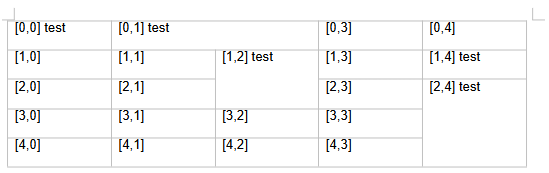

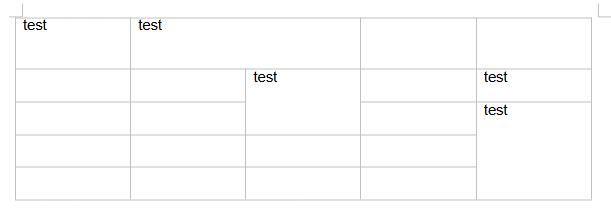

## Comments:

- The cell merging is done by comparing the current cell content (!) with the previous cell in the same row and column. If the cells are the same, the current cell is merged with the previous cell. If the cells have same content, there will false positive merges. Thats why I added cell coords as a prefix to the cell content to make it unique.
- So, this prefix must be removed after the merging.